In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Load data and transform 

In [32]:
df_raw = pd.read_csv('data/anova/Supabase Snippet Retrieve Valid Session Allocations (2).csv')
df = df_raw.drop(['trial_sequence_id', 'session_id'], axis=1)
df[['part1', 'part2']] = df['scenario_name'].str.split('_', expand=True)
df = df.drop('scenario_name', axis=1)

df

,allocation_fund_a,part1,part2
0,50,long,biased
1,50,long,unbiased
2,10,short,biased
3,30,short,unbiased
4,50,long,biased
...,...,...,...
73,60,short,unbiased
74,30,long,biased
75,50,long,unbiased
76,30,short,biased


## Data Summary

In [33]:
summary = df.groupby(['part1', 'part2'])['allocation_fund_a'].agg(['size', 'mean', 'std']).rename(columns={'size':'count'}).reset_index()
summary['se'] = summary['std'] / np.sqrt(summary['count'])

summary


,part1,part2,count,mean,std,se
0,long,biased,19,45.157895,25.364593,5.819037
1,long,unbiased,20,38.800000,25.266162,5.649686
2,short,biased,20,49.750000,19.431052,4.344915
3,short,unbiased,19,45.842105,23.807709,5.461863


## Distribution analysis

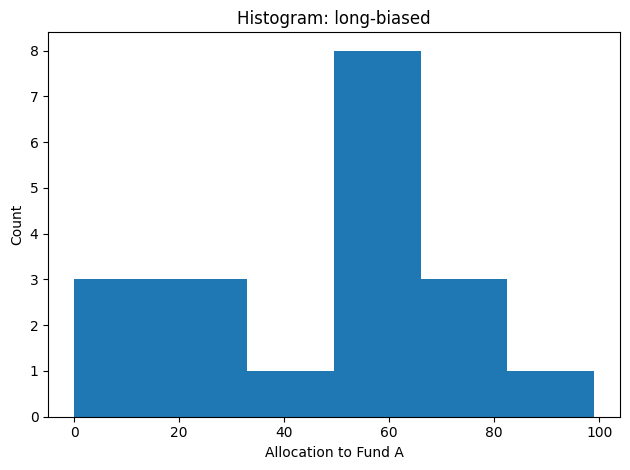

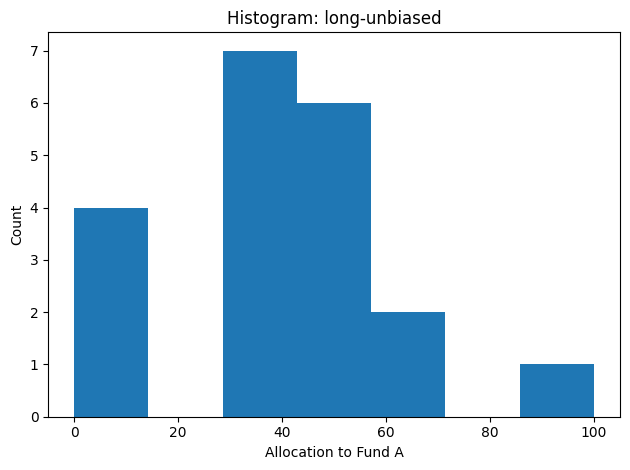

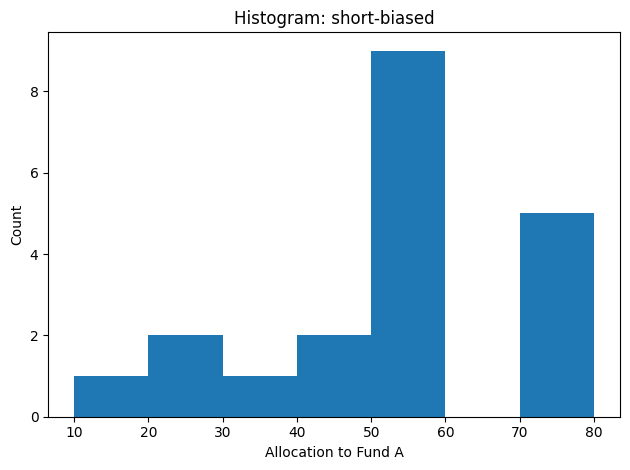

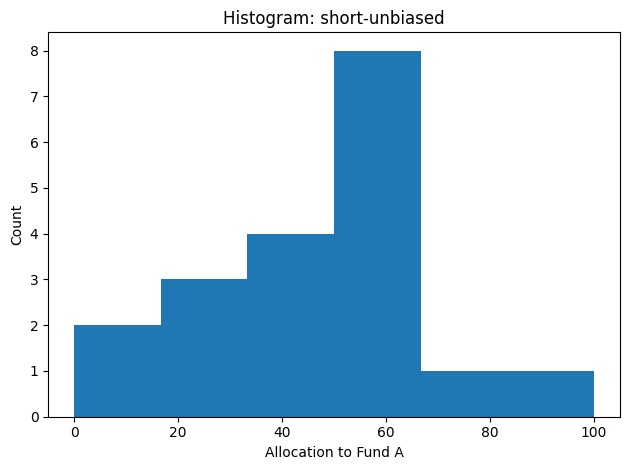

In [34]:
for (p1, p2), group in df.groupby(['part1', 'part2']):
    plt.figure()
    plt.hist(group['allocation_fund_a'], bins='auto')
    plt.xlabel('Allocation to Fund A')
    plt.ylabel('Count')
    plt.title(f'Histogram: {p1}-{p2}')
    plt.tight_layout()
    plt.show()

## Box Plot

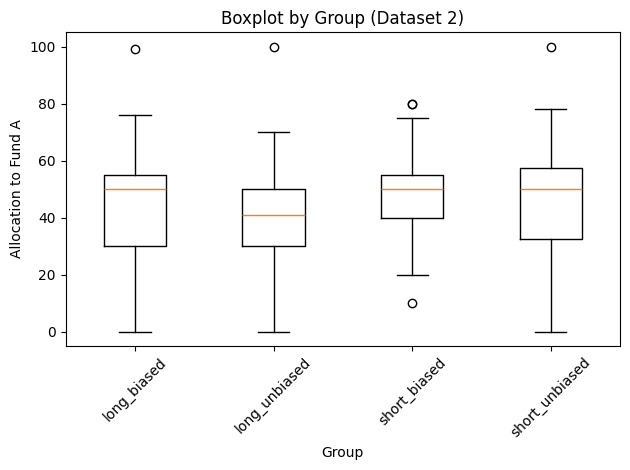

In [35]:
grouped = df.groupby(['part1','part2'])['allocation_fund_a'].apply(list)
labels = [f"{i[0]}_{i[1]}" for i in grouped.index]
plt.figure(); plt.boxplot(grouped.values); plt.xticks(range(1,len(labels)+1), labels, rotation=45)
plt.xlabel('Group'); plt.ylabel('Allocation to Fund A'); plt.title('Boxplot by Group (Dataset 2)'); plt.tight_layout(); plt.show()

## ANOVA

In [36]:
model = ols('allocation_fund_a ~ C(part1) * C(part2)', data=df).fit()
anova = sm.stats.anova_lm(model, typ=2)

anova


,sum_sq,df,F,PR(>F)
C(part1),659.421086,1.0,1.187683,0.279334
C(part2),513.421086,1.0,0.924723,0.339370
C(part1):C(part2),29.242949,1.0,0.052669,0.819115
Residual,41086.002632,74.0,NaN,NaN


## Interaction Plot

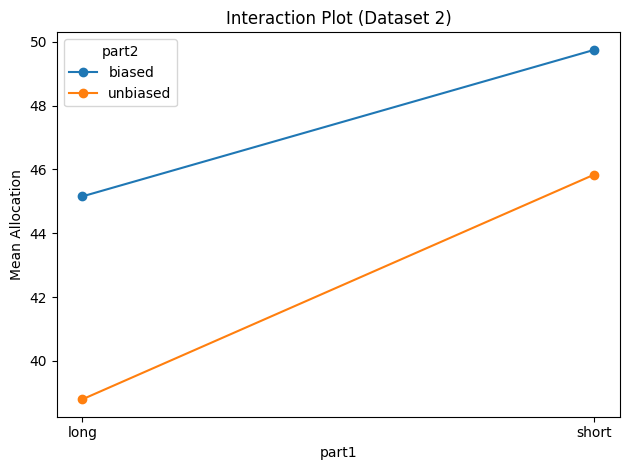

In [37]:
means = df.groupby(['part1','part2'])['allocation_fund_a'].mean().unstack('part2')
plt.figure()
for lvl in means.columns:
    plt.plot(means.index, means[lvl], marker='o', label=lvl)
plt.xlabel('part1'); plt.ylabel('Mean Allocation'); plt.title('Interaction Plot (Dataset 2)'); plt.legend(title='part2'); plt.tight_layout(); plt.show()

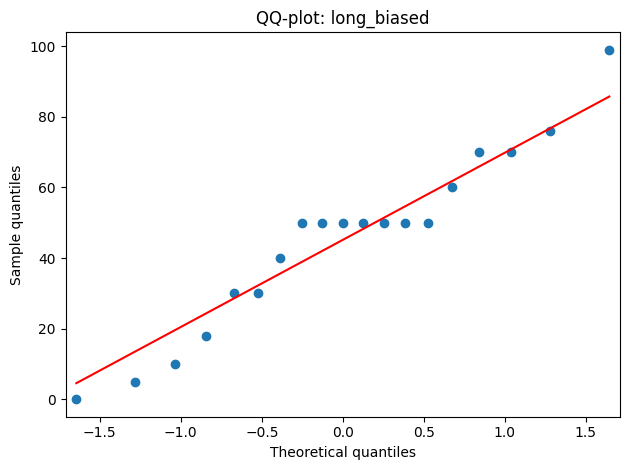

long_biased Shapiro–Wilk: W=0.952, p=0.428


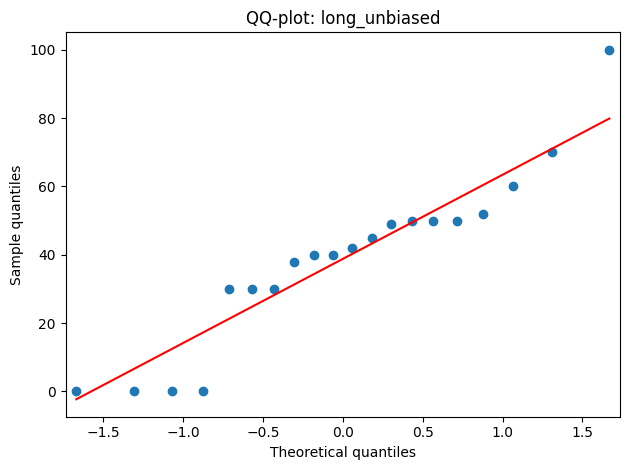

long_unbiased Shapiro–Wilk: W=0.911, p=0.067


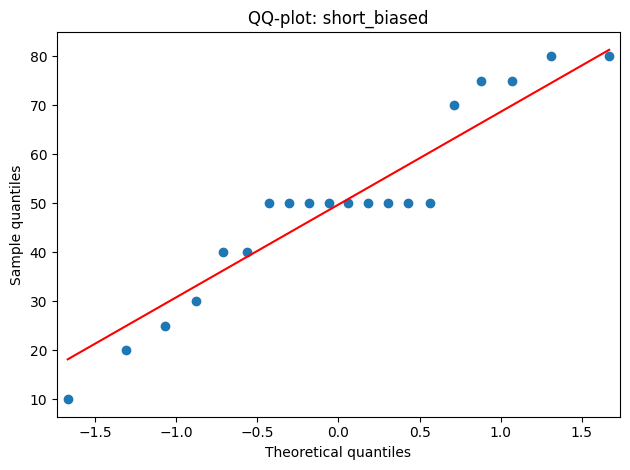

short_biased Shapiro–Wilk: W=0.914, p=0.077


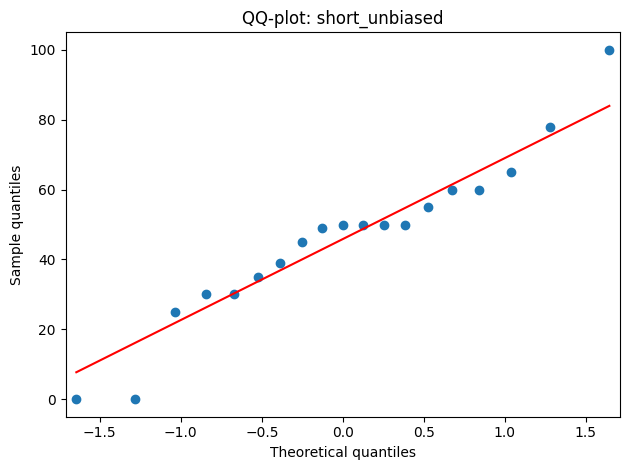

short_unbiased Shapiro–Wilk: W=0.952, p=0.426


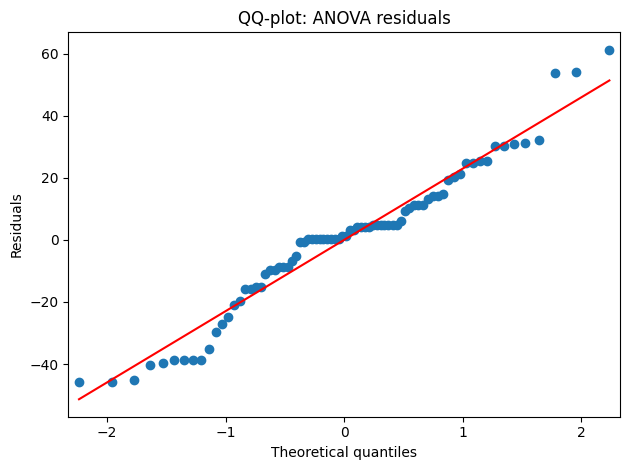

Residuals Shapiro–Wilk: W=0.962, p=0.019


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.formula.api import ols

# 1) load & transform
df_raw = pd.read_csv('data/anova/Supabase Snippet Retrieve Valid Session Allocations (2).csv')
df = df_raw.drop(['trial_sequence_id', 'session_id'], axis=1)
df[['part1', 'part2']] = df['scenario_name'].str.split('_', expand=True)
df = df.drop('scenario_name', axis=1)

# 2) QQ‑plots & Shapiro–Wilk for each part1×part2 cell
for (p1, p2), grp in df.groupby(['part1','part2']):
    plt.figure()
    sm.qqplot(grp['allocation_fund_a'], line='s', ax=plt.gca())
    plt.title(f'QQ‑plot: {p1}_{p2}')
    plt.xlabel('Theoretical quantiles')
    plt.ylabel('Sample quantiles')
    plt.tight_layout()
    plt.show()
    
    W, pval = shapiro(grp['allocation_fund_a'])
    print(f'{p1}_{p2} Shapiro–Wilk: W={W:.3f}, p={pval:.3f}')

# 3) QQ‑plot & Shapiro–Wilk on the ANOVA residuals
model = ols('allocation_fund_a ~ C(part1)*C(part2)', data=df).fit()
resid = model.resid

plt.figure()
sm.qqplot(resid, line='s', ax=plt.gca())
plt.title('QQ‑plot: ANOVA residuals')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

W_res, p_res = shapiro(resid)
print(f'Residuals Shapiro–Wilk: W={W_res:.3f}, p={p_res:.3f}')
